In this section, we will look at different factors that can affect the stability of your word embeddings, and ways to mitigate these issues in order to make your observations robust.

This notebook contains code to train various word2vec models using gensim, but we won't run them during the tutorial, in order to save time. Although you could run them yourself, I would not recommend using these settings for research or making design decisions about your experiments:

* for research, make sure you train larger models
* for design decisions, please consult the original papers, which show these effects over hundreds of runs.

This notebook is just for us to get a sense of how different things can get. Go ahead and run it for fun if you like, though!

In [58]:
import collections
import pickle
from gensim.models import Word2Vec
import random
import matplotlib.pyplot as plt
import seaborn as sns
import util

`build_w2v_model` is the function we will use to build all our models. I tried to make it somewhat realistic, but that means that I can't build them all during the tutorial. So we'll just have to use results "that I prepared earlier"!

In [59]:
def build_w2v_model(sentences, seed=0, num_workers=8):
  """Build a basic word2vec model using gensim.
  
  Args:
    sentences: corpus as list of lists of tokens
    seed: random seed (gensim.models.Word2Vec parameter)
    num_workers: number of threads to use (gensim.models.Word2Vec parameter)
    
  Returns:
    gensim.models.Word2Vec model
  """
  return Word2Vec(sentences=sentences, vector_size=100, window=5, min_count=10, workers=num_workers)
  
def embedding_corpus_from_docs(doc_list):
  """Build a corpus from training embeddings from a specific list of documents.
    Args:
      doc_list: list of documents, each in list of lists of tokens form
      
    Returns:
      A list of lists of tokens comprising sentences from all the documents in order.
  """
  corpus = []
  for doc in doc_list:
    corpus += doc
  return corpus

We will use a corpus of documents from /r/AskScience on Reddit, in the form of a dict:
```
{
"id_1": [
	["This", "is", "a", "sentence", "."],
	["This", "is", "another", "sentence", "."],
	],
"id_2": [
	["This", "is", "a", "third", "sentence ."], 
	["This", "is", "a", "fourth", "sentence", "."],
	],
...
}
```

The various preprocessing steps, etc. are hidden in `util.py`. For now, we will just retrieve them and not pay attention to the details.

In [60]:
askscience_docs = util.preprocess_askscience()

First, we will compare two models trained with different random seeds. Setting `num_workers=1` makes the gensim training deterministic.

\* Note: you can also get 'random' results by using a higher `num_workers`, but this is due to thread scheduling and is not reproducible. The tradeoff might be worth it though, since you can train a lot faster, and by the end of this tutorial we will have ways of dealing with randomness.

In [61]:
fixed_corpus = embedding_corpus_from_docs(list(askscience_docs.values()))

print("Starting")
w2v_1 = build_w2v_model(fixed_corpus, 23)
print("Built first model")
w2v_2 = build_w2v_model(fixed_corpus, 96)
print("Built second model")

Starting
Built first model
Built second model


We will compare two models using a list of salient words for /r/AskScience. I got these by doing some LDA shenanigans, but I am the least qualified person in the room to talk about LDA, so I will just gloss over that part.

One way to quantify the changes is to look at the difference in cosines calculated with the two models. We plot the 380 pairwise cosines in a scatter plot below:

/Users/nnayak/git_repos/embedding-tutorial/ve/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


0.024231303007783075


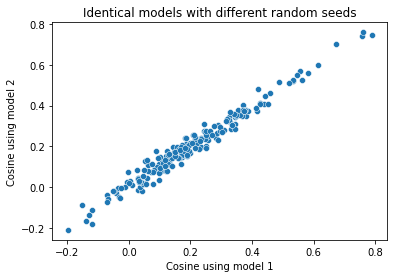

In [62]:
ASK_SCIENCE_WORDS = ["bacteria", "plant", "species", "brain",
"muscle", "sleep", "human", "galaxy",
 "space", "planet", "universe", "electricity",
 "light", "magnetic", "field", "power",
 "calorie", "chemical", "temperature", "pressure"]

def plot_cosine_changes(model_1, model_2, words, title):
  cosine_pairs = []

  for i, word1 in enumerate(words):
      for word2 in words[i+1:]:
          cosine_pairs.append((model_1.wv.similarity(word1, word2), model_2.wv.similarity(word1, word2) ))
  fig, ax = plt.subplots()
  x, y = zip(*cosine_pairs)
  sns.scatterplot(x, y, ax=ax)
  ax.set_xlabel("Cosine using model 1")
  ax.set_ylabel("Cosine using model 2")
  ax.set_title(title)
  
  print(sum(abs(x-y) for x, y in cosine_pairs)/len(cosine_pairs))
  
plot_cosine_changes(w2v_1, w2v_2, ASK_SCIENCE_WORDS, "Identical models with different random seeds")

Clearly, raw cosines are not very reliable -- while they haven't changed drastically, these are substantial changes considering both models were trained with the **exact same distribution of contexts**. 

A more realistic way to compare  we make qualitative judgments based on nearest neighbor lists. So instead, we should look at changes in nearest neighbor lists, and then try to quantify that change.

In [63]:
def compare_nearest_neighbors(model_1, model_2, words):
  for word in words:
    print(word)
    nn_1 = [x[0] for x in model_1.wv.most_similar(positive=[word])]
    nn_2 = [x[0] for x in model_2.wv.most_similar(positive=[word])]
    print(nn_1)
    print(nn_2)
    
compare_nearest_neighbors(w2v_1, w2v_2, ASK_SCIENCE_WORDS)

bacteria
['viruses', 'virus', 'microbes', 'microorganisms', 'pathogens', 'germs', 'parasites', 'venom', 'fungus', 'fungi']
['viruses', 'virus', 'microorganisms', 'germs', 'pathogens', 'microbes', 'fungus', 'antibodies', 'parasites', 'enzymes']
plant
['algae', 'seed', 'seeds', 'fossil', 'plants', 'fungus', 'host', 'coal', 'multicellular', 'soil']
['algae', 'seed', 'plants', 'fungus', 'biomass', 'tree', 'soil', 'seeds', 'fossil', 'leaf']
species
['organisms', 'animals', 'humans', 'traits', 'creature', 'creatures', 'homo', 'trait', 'mammals', 'neanderthals']
['organisms', 'humans', 'animals', 'creature', 'creatures', 'primates', 'organism', 'traits', 'offspring', 'populations']
brain
['body', 'memory', 'subconscious', 'brains', 'ear', 'consciousness', 'neurons', 'nerves', 'nerve', 'liver']
['body', 'subconscious', 'memory', 'consciousness', 'nerve', 'nerves', 'brains', 'neurons', 'ear', 'liver']
muscle
['muscles', 'fibers', 'tissue', 'bone', 'muscular', 'liver', 'metabolism', 'fat', 'liga

To quantify the change in nearest neighbors, we can measure (1) the proportion of the set of nearest neighbors that has changed and (2) the change in rank of the words that haven't changed.

bacteria 0.6666666666666666
plant 0.5384615384615384
species 0.42857142857142855
brain 1.0
muscle 0.6666666666666666
sleep 0.6666666666666666
human 0.5384615384615384
galaxy 0.8181818181818182
space 1.0
planet 0.8181818181818182
universe 0.8181818181818182
electricity 0.6666666666666666
light 0.8181818181818182
magnetic 0.6666666666666666
field 0.6666666666666666
power 0.6666666666666666
calorie 0.5384615384615384
chemical 0.5384615384615384
temperature 0.6666666666666666
pressure 0.5384615384615384


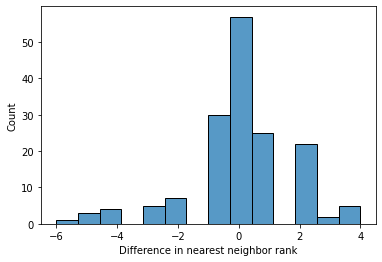

In [64]:
def jaccard(l1, l2):
  return len(set(l1).intersection(set(l2))) / len(set(l1).union(set(l2)))

def quantify_nn_change(model_1, model_2, words):
  rank_diffs = []

  for word in words:
    nn_1 = [x[0] for x in model_1.wv.most_similar(positive=[word])]
    nn_2 = [x[0] for x in model_2.wv.most_similar(positive=[word])]
    print(word, jaccard(nn_1, nn_2))
    for nn in nn_1:
      if nn not in nn_2:
        continue
      else:
        rank_diffs.append(nn_1.index(nn) - nn_2.index(nn))
  fig, ax = plt.subplots()
  sns.histplot(rank_diffs)
  ax.set_xlabel("Difference in nearest neighbor rank")
  
quantify_nn_change(w2v_1, w2v_2, ASK_SCIENCE_WORDS)

All of these changes are taking place for the exact same set of documents. However, changes to the set of documents can result in instability as well. Below, we train two models, each on 95% of the documents in the corpus.

In [65]:
keys1 = random.sample(sorted(askscience_docs.keys()), int(0.7 * len(askscience_docs))) # sampled without replacement
keys2 = random.sample(sorted(askscience_docs.keys()), int(0.7 * len(askscience_docs)))

w2v_1 = build_w2v_model( embedding_corpus_from_docs([askscience_docs[key] for key in keys1]))
print("Built first model")
w2v_2 = build_w2v_model( embedding_corpus_from_docs([askscience_docs[key] for key in keys2]))
print("Built second model")

Built first model
Built second model


0.02858621327598628


/Users/nnayak/git_repos/embedding-tutorial/ve/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
UsageError: Line magic function `%quantify_nn_change(w2v_1,` not found.


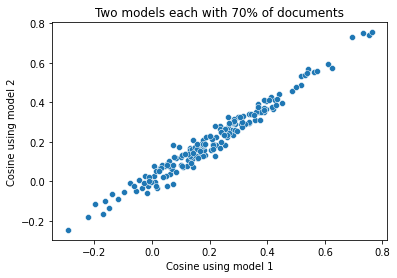

In [66]:
plot_cosine_changes(w2v_1, w2v_2, ASK_SCIENCE_WORDS, "Two models each with 70% of documents")

%quantify_nn_change(w2v_1, w2v_2, ASK_SCIENCE_WORDS)

0.031408457580561704


/Users/nnayak/git_repos/embedding-tutorial/ve/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


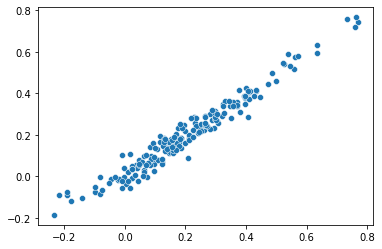

In [34]:

plot_cosine_changes(w2v_1, w2v_2, ASK_SCIENCE_WORDS)

# Show results here

This is really important because while a corpus of documents represents the mental model of the document creators, it represents only a *sample* of this mental model. We need to treat it in a statistically appropriate way. The fact that sampling can make such a huge difference indicates that we need to use bootstrapping (i.e. sampling with replacement).

Note that it is also possible to sample at the sentence level. While this gives much more appealing bounds, it is likely to be misleading -- a word's contexts all over a document are likely to be similar, and we aren't really excluding a particular usage of the word by just excluding some of its occurences in a document.

In [35]:
sentences1 = random.sample(fixed_corpus, int(0.7 * len(fixed_corpus)))
sentences2 = random.sample(fixed_corpus, int(0.7 * len(fixed_corpus)))

w2v_1 = build_w2v_model(sentences1)
print("Built first model")
w2v_2 = build_w2v_model(sentences2)
print("Built second model")

Built first model
Built second model


0.030292441825823566
bacteria 0.6666666666666666
plant 0.5384615384615384
species 0.5384615384615384
brain 0.5384615384615384
muscle 0.42857142857142855
sleep 0.6666666666666666
human 0.42857142857142855
galaxy 0.5384615384615384
space 0.6666666666666666
planet 0.8181818181818182
universe 0.8181818181818182
electricity 0.6666666666666666
light 0.42857142857142855
magnetic 0.8181818181818182
field 0.5384615384615384
power 0.42857142857142855
calorie 0.6666666666666666
chemical 0.5384615384615384
temperature 0.6666666666666666
pressure 0.5384615384615384


/Users/nnayak/git_repos/embedding-tutorial/ve/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


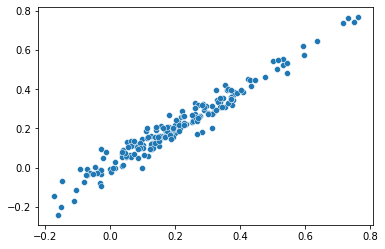

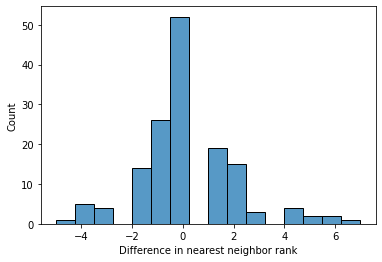

In [36]:
plot_cosine_changes(w2v_1, w2v_2, ASK_SCIENCE_WORDS)
quantify_nn_change(w2v_1, w2v_2, ASK_SCIENCE_WORDS)

# Show results for sentence-level sampling here

The way to ensure robust results is to use bootstrapping, and report aggregated results over multiple runs.

In [38]:
BOOTSTRAP_NUM = 20
import tqdm

bootstrap_models_1 = []
for i in tqdm.tqdm(range(BOOTSTRAP_NUM)):
  selected_keys = random.choices(sorted(askscience_docs.keys()), k=len(askscience_docs.keys()))
  bootstrap_models_1.append(build_w2v_model(embedding_corpus_from_docs([askscience_docs[key] for key in selected_keys])))


100%|█████████████████████████████████████████████| 20/20 [06:05<00:00, 18.29s/it]


Let's compare this with another set of 20 bootstrapped models.

In [39]:
bootstrap_models_2 = []
for i in tqdm.tqdm(range(BOOTSTRAP_NUM)):
  selected_keys = random.choices(sorted(askscience_docs.keys()), k=len(askscience_docs.keys()))
  bootstrap_models_2.append(build_w2v_model(embedding_corpus_from_docs([askscience_docs[key] for key in selected_keys])))

100%|█████████████████████████████████████████████| 20/20 [05:56<00:00, 17.83s/it]


We can compare the nearest neighbors by aggregating their ranks over each run.

In [57]:
import numpy as np

def aggregate_nearest_neighbors(words, model_list):
  nearest_neighbor_rank_counter = collections.defaultdict(lambda:collections.defaultdict(list))
  for model in model_list:
    for word in words:
      for i, nn in enumerate(model.wv.most_similar(positive=[word])):
        nearest_neighbor_rank_counter[word][nn[0]].append(i+1)

  var_list = []
  for k, v in nearest_neighbor_rank_counter.items():
    print(k)
    for a, b in v.items():
      print(a, np.mean(b), np.var(b))
      var_list.append(np.var(b))
      
  print(np.mean(var_list))
    
aggregate_nearest_neighbors(ASK_SCIENCE_WORDS, bootstrap_models_1)

bacteria
viruses 1.0 0.0
microbes 5.125 5.734375
virus 2.8 1.56
germs 5.444444444444445 5.802469135802469
fungi 8.25 3.4375
microorganisms 5.142857142857143 5.265306122448979
pathogens 4.777777777777778 3.5061728395061724
fungus 5.75 7.0625
mold 9.0 0.0
yeast 8.0 2.0
enzymes 7.222222222222222 3.9506172839506175
antibodies 6.333333333333333 2.2222222222222223
antibiotics 8.4 2.04
nutrients 6.0 0.0
parasites 6.333333333333333 2.888888888888889
seeds 6.75 5.1875
proteins 7.8 2.16
diseases 8.0 0.0
organisms 9.5 0.25
strains 8.0 2.0
antibiotic 9.0 0.0
parasite 10.0 0.0
host 7.0 0.0
crops 9.0 0.0
venom 8.333333333333334 1.5555555555555556
chemicals 8.333333333333334 0.888888888888889
oils 6.0 0.0
toxins 6.5 6.25
plant
tree 6.75 7.9375
plants 2.65 1.8275
algae 2.5294117647058822 2.0138408304498268
seed 1.9 1.29
soil 5.315789473684211 4.426592797783933
seeds 6.083333333333333 5.076388888888888
fungus 5.636363636363637 4.413223140495868
host 5.571428571428571 6.244897959183674
coal 6.8571428571

In [48]:
aggregate_nearest_neighbors(ASK_SCIENCE_WORDS, bootstrap_models_2)

bacteria
viruses 1.05 0.04750000000000001
microorganisms 5.083333333333333 2.7430555555555554
virus 2.35 0.6275
venom 8.0 6.0
antibiotics 7.083333333333333 5.076388888888889
parasites 6.625 2.984375
antibodies 6.666666666666667 1.888888888888889
nutrients 9.0 1.0
seeds 7.333333333333333 2.222222222222222
germs 5.166666666666667 5.138888888888889
microbes 4.722222222222222 3.533950617283951
fungus 6.5 5.392857142857143
proteins 8.0 0.5
toxins 7.25 9.6875
pathogens 5.315789473684211 5.373961218836565
fungi 5.666666666666667 0.22222222222222224
chemicals 10.0 0.0
strains 7.875 2.609375
yeast 8.428571428571429 2.244897959183674
pathogen 10.0 0.0
flora 8.0 0.0
organisms 8.333333333333334 2.8888888888888893
antibiotic 8.5 2.25
diseases 7.0 0.0
mold 10.0 0.0
enzymes 7.0 0.0
seed 8.5 0.25
infection 10.0 0.0
plant
plants 2.9 2.79
algae 2.7 5.8100000000000005
soil 5.625 3.609375
tree 4.777777777777778 2.8395061728395063
snake 5.0 0.0
fossil 7.0 3.3333333333333335
crops 7.8 2.16
seed 2.4 3.04
coa

density 9.0 1.3333333333333333
fluid 8.375 3.234375
temp 10.0 0.0
tension 8.666666666666666 0.888888888888889
gradient 9.5 0.25
currents 7.7272727272727275 6.016528925619835
voltage 7.0 0.6666666666666666
buoyancy 6.6 3.44
atmospheric 8.333333333333334 5.5555555555555545
circulation 6.5 2.25
airflow 6.0 0.0
evaporation 9.0 0.0
psi 10.0 0.0
salinity 9.0 0.0
altitude 10.0 0.0
conductivity 3.0 0.0
compression 7.0 1.0
flow 9.0 0.0


In [67]:
# BOOTSTRAP_NUM = 20
# import tqdm

# bad_bootstrap_models_1 = []
# for i in tqdm.tqdm(range(BOOTSTRAP_NUM)):
#   selected_keys = random.choices(fixed_corpus, k=len(fixed_corpus))
#   bad_bootstrap_models_1.append(build_w2v_model(fixed_corpus))

# bad_bootstrap_models_2 = []
# for i in tqdm.tqdm(range(BOOTSTRAP_NUM)):
#   selected_keys = random.choices(fixed_corpus, k=len(fixed_corpus))
#   bad_bootstrap_models_2.append(build_w2v_model(fixed_corpus))




In [56]:
aggregate_nearest_neighbors(ASK_SCIENCE_WORDS, bad_bootstrap_models_2)

bacteria
viruses 1.0 0.0
fungus 6.05 3.9475000000000002
pathogens 4.4 2.2399999999999998
virus 2.65 1.0274999999999999
microbes 3.7 2.11
microorganisms 5.45 2.9475
germs 5.5 1.65
antibiotics 9.0 1.0
enzymes 8.625 0.484375
seeds 9.142857142857142 0.9795918367346939
parasites 8.0 2.0
yeast 8.5 0.25
strains 9.333333333333334 0.888888888888889
bacterium 9.0 0.0
fungi 10.0 0.0
antibodies 8.6 0.24000000000000005
venom 8.625 1.234375
flora 10.0 0.0
proteins 9.0 0.0
pathogen 9.0 0.0
plant
seed 1.45 0.24749999999999997
algae 1.65 0.42750000000000005
soil 4.105263157894737 1.7783933518005541
plants 3.65 0.6275
host 8.133333333333333 2.782222222222223
seeds 6.923076923076923 0.8402366863905327
colony 8.272727272727273 3.6528925619834705
fossil 7.444444444444445 2.2469135802469133
leaf 7.3 2.41
biomass 7.555555555555555 3.0246913580246915
fungus 4.7894736842105265 2.2714681440443214
mineral 8.0 0.0
organism 7.333333333333333 1.222222222222222
bacteria 8.714285714285714 1.0612244897959182
coal 8.8 